In [36]:
import os
import cv2
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import yaml



In [37]:
np.random.seed(42)

# Set the path to the dataset
dataset_path = '.'

# Set the paths to images and annotations
images_folder = os.path.join(dataset_path, 'Images')
annotations_folder = os.path.join(dataset_path, 'Bounding_Boxes')

# Model configuration
input_shape = (512, 512, 3)  # Adjust based on your image size

In [38]:
class BoundingBox:
    def __init__(self, xmin, ymin, xmax, ymax, class_id, img_path):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.class_id = class_id
        self.img_path = img_path

    def __repr__(self):
        return f'[{self.xmin}, {self.ymin}, {self.xmax}, {self.ymax} | {self.class_id}]'


In [39]:
# Data preprocessing and loading
def load_data():
    images = []
    annotations = []
    label_map = {}

    # Open Bounding_Boxes/darknet.labels and read class names and put into label_map
    with open(os.path.join(annotations_folder, 'darknet.labels'), 'r') as f:
        class_names = f.readlines()
        for i, class_name in enumerate(class_names):
            label_map[i] = class_name.strip()

    # return images, labels
    for annotation_name in os.listdir(annotations_folder):

        # If no .txt files, continue
        if not annotation_name.endswith('.txt'):
            continue

        # Load image
        image_name = annotation_name.replace('.txt', '.jpg')
        image_path = os.path.join(images_folder, image_name)
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        original_image_width, original_image_height = image.shape[1], image.shape[0]
        image = cv2.resize(image, (input_shape[0], input_shape[1]))

        images.append(image)

        # Load annotations
        annotation_path = os.path.join(annotations_folder, annotation_name)
        with open(annotation_path, 'r') as f:
            # Parse bounding box coordinates and class label
            # Example format: class x_min y_min x_max y_max
            lines = f.readlines()
            sub_annotations = []
            for line in lines:
                line = line.strip().split(' ')
                class_label, x_center_relativ, y_center_relativ, width_relativ, height_relativ = map(float, line)

                # Convert normalized coordinates to absolute coordinates
                x_min = int((x_center_relativ - width_relativ / 2) * original_image_width)
                y_min = int((y_center_relativ - height_relativ / 2) * original_image_height)
                x_max = int((x_center_relativ + width_relativ / 2) * original_image_width)
                y_max = int((y_center_relativ + height_relativ / 2) * original_image_height)

                # Rescale coordinates to input_shape
                x_min = int(x_min * input_shape[0] / original_image_width)
                y_min = int(y_min * input_shape[1] / original_image_height)
                x_max = int(x_max * input_shape[0] / original_image_width)
                y_max = int(y_max * input_shape[1] / original_image_height)

                # Store annotation information
                sub_annotations.append(BoundingBox(x_min, y_min, x_max, y_max, int(class_label), image_path))

            annotations.append(sub_annotations)

    # images = np.array(images)

    return images, annotations, label_map


# Load and preprocess the data
images, annotations, label_map = load_data()

images, len(annotations), label_map


([array([[[254, 254, 254],
          [255, 255, 255],
          [254, 254, 254],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[254, 254, 254],
          [255, 255, 255],
          [254, 254, 254],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254],
          ...,
          [254, 254, 254],
          [254, 254, 254],
          [254, 254, 254]],
  
         ...,
  
         [[255, 255, 255],
          [254, 254, 254],
          [254, 254, 254],
          ...,
          [254, 254, 254],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254],
          ...,
          [254, 254, 254],
          [254, 254, 254],
          [254, 254, 254]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255

In [40]:
annotations[0]


[[6, 11, 165, 494 | 2],
 [177, 14, 333, 472 | 2],
 [350, 13, 501, 475 | 2],
 [25, 21, 142, 63 | 0],
 [194, 19, 315, 65 | 0],
 [363, 17, 488, 65 | 0],
 [8, 76, 162, 166 | 1],
 [8, 178, 160, 256 | 1],
 [8, 281, 161, 359 | 1],
 [9, 380, 162, 463 | 1],
 [179, 74, 332, 157 | 1],
 [178, 177, 332, 258 | 1],
 [178, 275, 332, 357 | 1],
 [178, 381, 332, 458 | 1],
 [351, 75, 500, 154 | 1],
 [353, 176, 500, 260 | 1],
 [352, 278, 500, 363 | 1],
 [352, 381, 500, 462 | 1]]

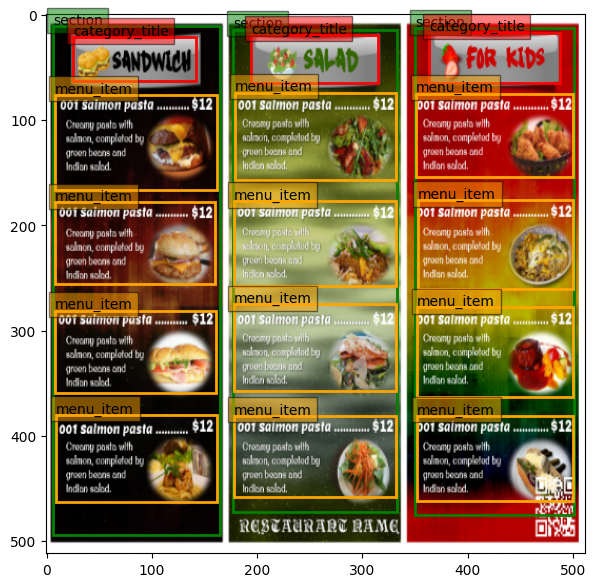

In [41]:
# Helper function to visualize bounding boxes
# It takes an image and a list of bounding boxes as inputs and plots an image with all the bounding boxes
# Each bounding box class should have a different color

color_map = {0: 'red', 1: 'orange', 2: 'green'}

def visualize_bounding_boxes(image, annotations):
    plt.imshow(image)
    ax = plt.gca()

    for annotation in annotations:
        xmin, ymin, xmax, ymax, class_id = annotation.xmin, annotation.ymin, annotation.xmax, annotation.ymax, annotation.class_id

        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=color_map[class_id], linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 2, label_map[class_id], bbox=dict(facecolor=color_map[class_id], alpha=0.5))


plt.figure(figsize=(7, 7))

visualize_bounding_boxes(images[0], annotations[0])
plt.show()




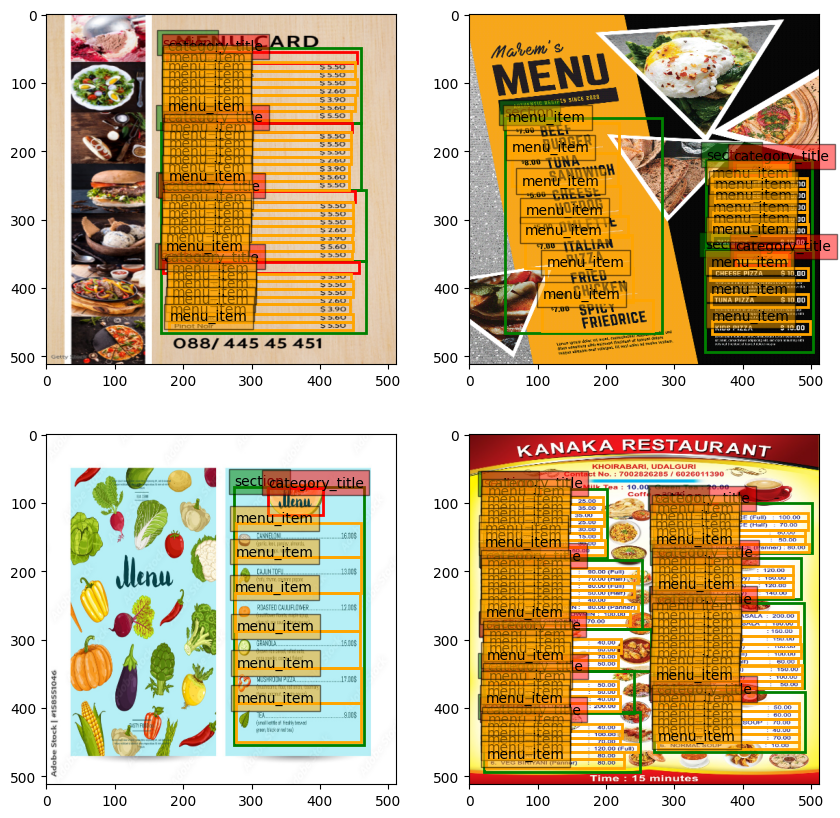

In [42]:
# Draw 4 randim images with bounding boxes in a 2x2 grid
plt.figure(figsize=(10, 10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    random_index = np.random.randint(len(images))
    visualize_bounding_boxes(images[random_index], annotations[random_index])
plt.show()

In [43]:
def create_dir_or_clean(path):
    os.makedirs(path, exist_ok=True)
    for file in os.listdir(path):
        os.remove(os.path.join(path, file))

def save_images_and_txt_files(images, annotations, image_path, label_path, file_base_name):
    for i, (train_image, train_annotation) in enumerate(zip(images, annotations)):
        image_name = f'{file_base_name}_{i}.jpg'
        label_name = f'{file_base_name}_{i}.txt'

        # Write the image to disk using cv2. Keep in mind that the images are in RGB and cv2 uses BGR by default
        cv2.imwrite(os.path.join(image_path, image_name), cv2.cvtColor(train_image, cv2.COLOR_RGB2BGR))

        with open(os.path.join(label_path, label_name), 'w') as f:
            for annotation in train_annotation:
                f.write(f"{annotation[0]} {annotation[1]} {annotation[2]} {annotation[3]} {annotation[4]}\n")


In [47]:

# THis function has the following responsibilities:
# 1. Convert the annotations into the YOLO format
# 2. Split the data into train and validation sets
# 3. Save the data final_datasdet/images/train, final_datasdet/images/val and final_datasdet/labels/train, final_datasdet/labels/val
# 4. Save the label_map into final_datasdet/labels/darknet.labels
# 5. save the yolo configuration yaml file
def save_for_yolo_training(images, annotations):
    # Convert annotations into YOLO format
    yolo_annotations = []
    for sub_annotations in annotations:
        yolo_annotations.append([])
        for annotation in sub_annotations:
            x_center = (annotation.xmin + annotation.xmax) / 2
            y_center = (annotation.ymin + annotation.ymax) / 2
            width = annotation.xmax - annotation.xmin
            height = annotation.ymax - annotation.ymin

            # Normalize coordinates
            x_center /= input_shape[0]
            y_center /= input_shape[1]
            width /= input_shape[0]
            height /= input_shape[1]

            yolo_annotations[-1].append([annotation.class_id, x_center, y_center, width, height])

    # Split into train and validation sets
    train_images, val_images, train_annotations, val_annotations = train_test_split(images, yolo_annotations, test_size=0.2, shuffle=True, random_state=42)

    # Create the directories
    image_train_path = 'final_dataset/images/train'
    image_val_path = 'final_dataset/images/val'
    label_train_path = 'final_dataset/labels/train'
    label_val_path = 'final_dataset/labels/val'
    create_dir_or_clean(image_train_path)
    create_dir_or_clean(image_val_path)
    create_dir_or_clean(label_train_path)
    create_dir_or_clean(label_val_path)

    # Save the images and labels
    save_images_and_txt_files(train_images, train_annotations, image_train_path, label_train_path, 'train')
    save_images_and_txt_files(val_images, val_annotations, image_val_path, label_val_path, 'val')

    # Copy the darknet.labels file to label train and val paths
    os.system(f'cp {os.path.join(annotations_folder, "darknet.labels")} {label_train_path}')
    os.system(f'cp {os.path.join(annotations_folder, "darknet.labels")} {label_val_path}')

    # Create and save the yolo configuration file
    yolo_config = {
        'path': os.path.abspath('final_dataset'),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(label_map),
        'names': label_map,

    }
    yaml.dump(yolo_config, open('final_dataset/yolo_config.yaml', 'w'))


save_for_yolo_training(images, annotations)


In [48]:
from ultralytics import YOLO

model = YOLO("yolov8n.yaml").load("yolov8n.pt") # from local file

results = model.train(data = "./final_dataset/yolo_config.yaml", epochs = 12)



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 16.2MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

YOLOv8n summary: 225 layers, 3011433 parameters, 3011417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train2', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /home/niklas/uni/semester7/dasc2/data-challenge-project/Menu_Card_Transformation/final_dataset/labels/train... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 676.38it/s]

train: New cache created: /home/niklas/uni/semester7/dasc2/data-challenge-project/Menu_Card_Transformation/final_dataset/labels/train.cache



val: Scanning /home/niklas/uni/semester7/dasc2/data-challenge-project/Menu_Card_Transformation/final_dataset/labels/val... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 1042.58it/s]

val: New cache created: /home/niklas/uni/semester7/dasc2/data-challenge-project/Menu_Card_Transformation/final_dataset/labels/val.cache


Plotting labels to /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


/home/niklas/uni/semester7/dasc2/data-challenge-project/data-challenge-env/lib/python3.8/site-packages/torch/nn/functional.py:2443: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if size_prods == 1:


Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train2
Starting training for 12 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/12       1.3G      3.716      3.764       2.98        452        640: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all          3         81     0.0196      0.274     0.0469      0.016



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/12      1.24G      3.102      3.835      2.466        376        640: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]

                   all          3         81     0.0183       0.25     0.0394     0.0143


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/12      1.16G      3.284      3.636      2.672        216        640: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all          3         81     0.0171      0.226     0.0376     0.0137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/12      1.16G      3.255      3.809      2.712        219        640: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all          3         81     0.0171      0.226     0.0398     0.0152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/12      1.16G      3.547      3.831      2.819        218        640: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

                   all          3         81      0.018      0.232     0.0401     0.0155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/12      1.17G      3.331      3.739      2.772        219        640: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]

                   all          3         81     0.0206       0.28     0.0537     0.0211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/12      1.18G      3.101      3.638      2.517        216        640: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.90it/s]

                   all          3         81     0.0214      0.286     0.0548      0.024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/12      1.18G      3.327      3.748      2.614        213        640: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.69it/s]

                   all          3         81     0.0227       0.31      0.059     0.0255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/12      1.18G      3.106      3.631      2.472        211        640: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.70it/s]

                   all          3         81     0.0225       0.31     0.0528     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/12      1.22G      3.027      3.567      2.418        204        640: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all          3         81     0.0227       0.31     0.0541     0.0247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/12      1.18G      2.926      3.638      2.246        216        640: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.41it/s]

                   all          3         81     0.0228       0.31     0.0707     0.0278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/12      1.23G      2.937      3.618      2.379        204        640: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.51it/s]

                   all          3         81     0.0239      0.333     0.0849     0.0362



12 epochs completed in 0.004 hours.
Optimizer stripped from /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train2/weights/best.pt, 6.2MB

Validating /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.8.10 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1070 Ti, 8192MiB)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.23it/s]


                   all          3         81     0.0239      0.333     0.0829     0.0361
        category_title          3         13    0.00712      0.154     0.0321      0.015
             menu_item          3         54     0.0326      0.204     0.0461     0.0117
               section          3         14     0.0319      0.643       0.17     0.0817
Speed: 0.4ms preprocess, 6.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train2
